# Neural_network_with_defined_body_forces_and_predefined_constants

/usr/local/lib/python3.11/dist-packages/keras/src/optimizers/base_optimizer.py:774: UserWarning: Gradients do not exist for variables ['pinn/dense_4/bias'] when minimizing the loss. If using `model.compile()`, did you forget to provide a `loss` argument?
  warnings.warn(


Epoch 0, Loss: 2.0365e+03
Epoch 100, Loss: 2.7535e+02
Epoch 200, Loss: 8.1451e+00
Epoch 300, Loss: 1.8069e+00
Epoch 400, Loss: 9.5933e-01
Epoch 500, Loss: 6.3674e-01
Epoch 600, Loss: 4.6338e-01
Epoch 700, Loss: 3.5450e-01
Epoch 800, Loss: 2.8053e-01
Epoch 900, Loss: 2.6247e-01


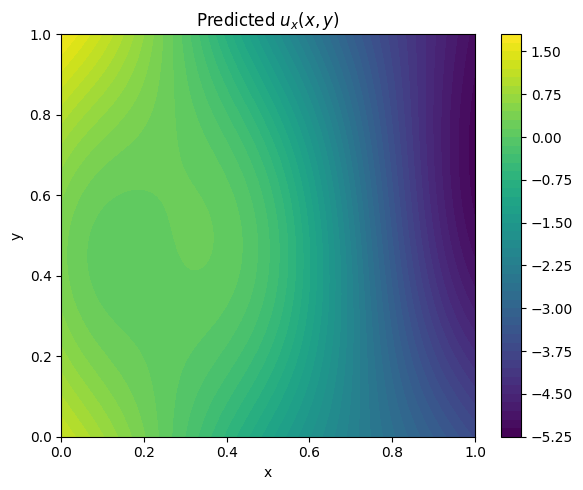

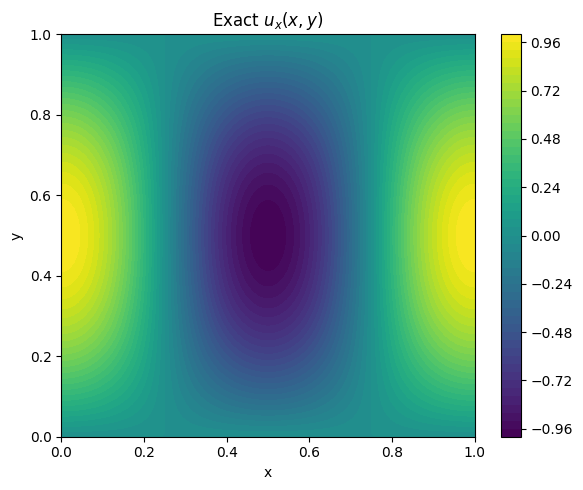

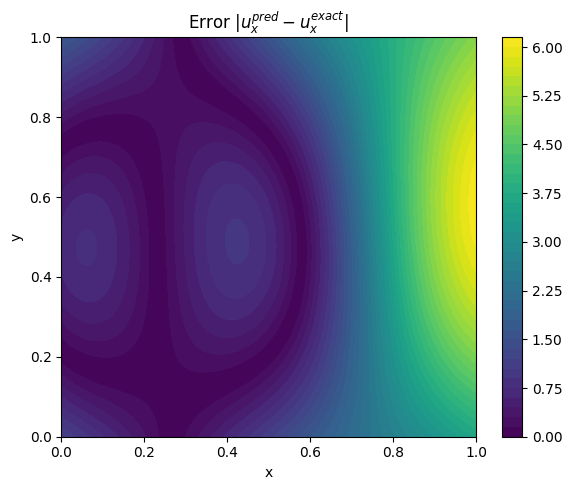

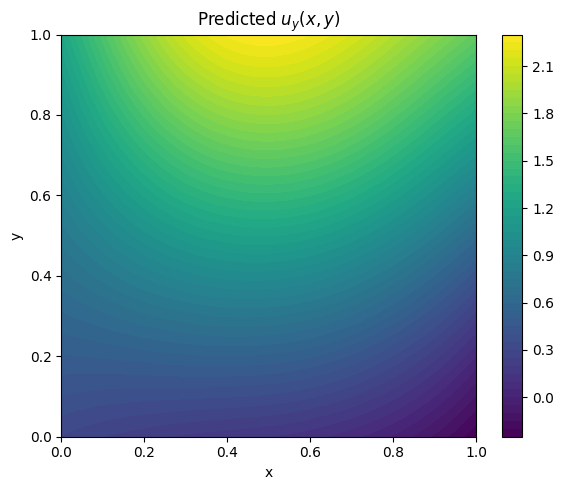

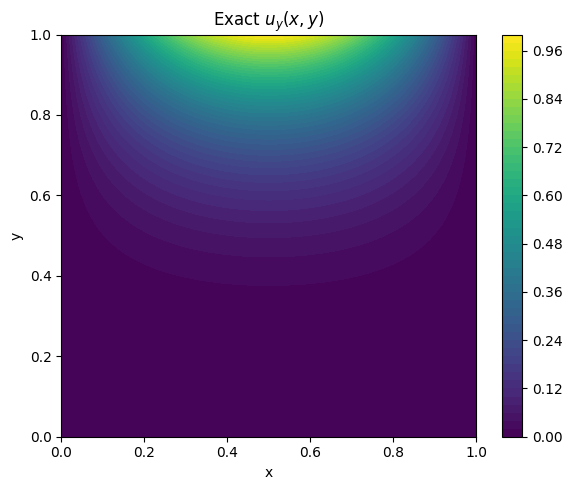

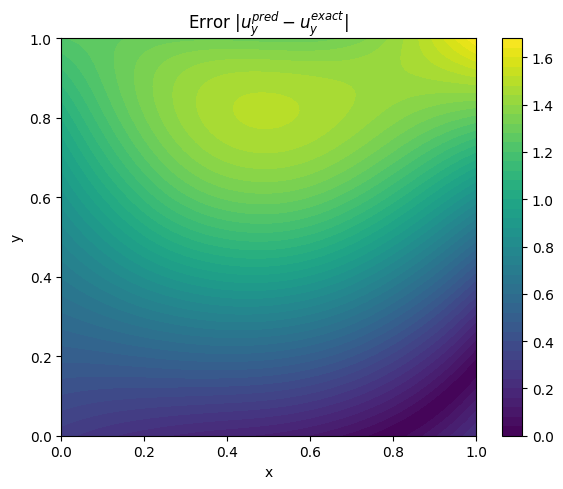

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

# Set float precision for TensorFlow
tf.keras.backend.set_floatx('float32')

# Constants (Lamé parameters and Q)
lambda_val = 1.0
mu_val = 0.5
Q_val = 4.0
pi = np.pi

# Body force functions (from manufactured solution)
def body_forces(x, y):
    fx = lambda_val * (4 * pi**2 * np.cos(2*pi*x) * np.sin(pi*y) - pi * np.cos(pi*x) * Q_val * y**3) \
       + mu_val * (9 * pi**2 * np.cos(2*pi*x) * np.sin(pi*y) - pi * np.cos(pi*x) * Q_val * y**3)

    fy = lambda_val * (-3 * np.sin(pi*x) * Q_val * y**2 + 2 * pi**2 * np.sin(2*pi*x) * np.cos(pi*y)) \
       + mu_val * (-6 * np.sin(pi*x) * Q_val * y**2 + 2 * pi**2 * np.sin(2*pi*x) * np.cos(pi*y) + pi**2 * np.sin(pi*x) * Q_val * y**4 / 4)

    return fx, fy

# PINN Model
class PINN(tf.keras.Model):
    def __init__(self):
        super().__init__()
        self.hidden = [tf.keras.layers.Dense(50, activation='tanh') for _ in range(4)]
        self.out = tf.keras.layers.Dense(2)  # Outputs: u_x, u_y

    def call(self, x):
        for layer in self.hidden:
            x = layer(x)
        return self.out(x)

# Generate collocation points
N = 10000
x_train = np.random.rand(N, 1)
y_train = np.random.rand(N, 1)
xy_train = tf.convert_to_tensor(np.hstack([x_train, y_train]), dtype=tf.float32)

# Compute body forces
fx_np, fy_np = body_forces(x_train, y_train)
fx_train = tf.convert_to_tensor(fx_np, dtype=tf.float32)
fy_train = tf.convert_to_tensor(fy_np, dtype=tf.float32)

# Initialize model and optimizer
model = PINN()
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)

# Training step
@tf.function
def train_step(xy, fx_true, fy_true):
    with tf.GradientTape(persistent=True) as tape:
        tape.watch(xy)
        u = model(xy)
        u_x = u[:, 0:1]
        u_y = u[:, 1:2]

        grads_u = tape.batch_jacobian(u, xy)
        u_xx = grads_u[:, 0:1, 0]
        u_xy = grads_u[:, 0:1, 1]
        u_yx = grads_u[:, 1:2, 0]
        u_yy = grads_u[:, 1:2, 1]

        eps_xx = u_xx
        eps_yy = u_yy
        eps_xy = 0.5 * (u_xy + u_yx)
        trace = eps_xx + eps_yy

        sigma_xx = lambda_val * trace + 2 * mu_val * eps_xx
        sigma_yy = lambda_val * trace + 2 * mu_val * eps_yy
        sigma_xy = 2 * mu_val * eps_xy

        sigma_xx_x = tape.batch_jacobian(sigma_xx, xy)[:, 0:1, 0]
        sigma_xy_y = tape.batch_jacobian(sigma_xy, xy)[:, 0:1, 1]
        sigma_yy_y = tape.batch_jacobian(sigma_yy, xy)[:, 0:1, 1]
        sigma_xy_x = tape.batch_jacobian(sigma_xy, xy)[:, 0:1, 0]

        res_fx = sigma_xx_x + sigma_xy_y
        res_fy = sigma_xy_x + sigma_yy_y

        loss = tf.reduce_mean(tf.square(res_fx - fx_true)) + tf.reduce_mean(tf.square(res_fy - fy_true))

    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))
    return loss

# Training loop
for epoch in range(1000):
    loss = train_step(xy_train, fx_train, fy_train)
    if epoch % 100 == 0:
        print(f"Epoch {epoch}, Loss: {loss.numpy():.4e}")

# Prediction on grid
x_vals = np.linspace(0, 1, 100)
y_vals = np.linspace(0, 1, 100)
X, Y = np.meshgrid(x_vals, y_vals)
XY_grid = np.stack([X.ravel(), Y.ravel()], axis=1)
XY_tensor = tf.convert_to_tensor(XY_grid, dtype=tf.float32)

# Predict displacements
u_pred = model(XY_tensor).numpy()
u_pred_x = u_pred[:, 0].reshape(100, 100)
u_pred_y = u_pred[:, 1].reshape(100, 100)

# Exact solutions
u_exact_x = np.cos(2 * pi * X) * np.sin(pi * Y)
u_exact_y = np.sin(pi * X) * Q_val * Y**4 / 4

# Plotting function
def plot_contour(Z, title):
    plt.figure(figsize=(6, 5))
    cp = plt.contourf(X, Y, Z, 50, cmap='viridis')
    plt.colorbar(cp)
    plt.title(title)
    plt.xlabel('x')
    plt.ylabel('y')
    plt.tight_layout()
    plt.show()

# Plot predictions and errors
plot_contour(u_pred_x, 'Predicted $u_x(x, y)$')
plot_contour(u_exact_x, 'Exact $u_x(x, y)$')
plot_contour(np.abs(u_pred_x - u_exact_x), 'Error $|u_x^{pred} - u_x^{exact}|$')

plot_contour(u_pred_y, 'Predicted $u_y(x, y)$')
plot_contour(u_exact_y, 'Exact $u_y(x, y)$')
plot_contour(np.abs(u_pred_y - u_exact_y), 'Error $|u_y^{pred} - u_y^{exact}|$')
